from Nancy

This notebook generates forcing files for the 2D domain.

Plan: use 3D boundary files, average across the mouth of Juan de Fuca and set uniformly across domain. 

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import os

#from salishsea_tools import tidetools,nc_tools

%matplotlib inline

# Load 3D T+S


In [2]:
f = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/SalishSea2_Masson_DC.nc')

T = f.variables['votemper'][:]
S = f.variables['vosaline'][:]
print( S.shape)
depth = f.variables['deptht'][:]
times = f.variables['time_counter'][:]


(52, 40, 1, 870)


There are 52 weeks, 40 depth levels, 87 points across mouth, and 10 points into domain.

# Average across mouth 

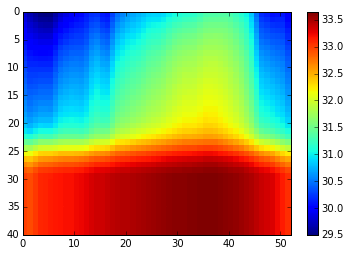

In [3]:
ntime=52; ndepth=40; nrim = 10

width_3d=87
Tmean = np.zeros((ntime,ndepth,nrim))
Smean = np.zeros((ntime,ndepth,nrim))
for i in np.arange(nrim):
    ind = i*width_3d
    Tmean[:,:,i] = np.nanmean(T[:,:,0,ind:ind+width_3d], axis=2)
    Smean[:,:,i] = np.nanmean(S[:,:,0,ind:ind+width_3d], axis=2)
    
plt.pcolormesh(Smean[:,:,0].T)
plt.axis([0,ntime,ndepth,0])
plt.colorbar()



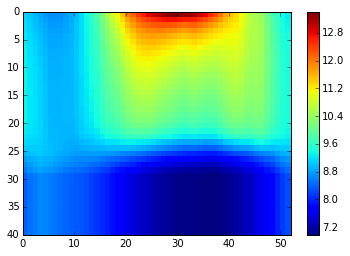

In [4]:
plt.pcolormesh(Tmean[:,:,0].T)
plt.axis([0,ntime,ndepth,0])
plt.colorbar()

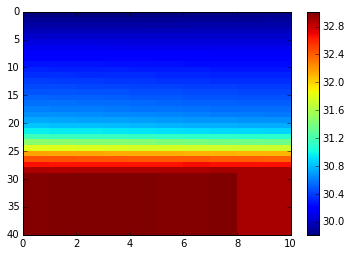

In [5]:
plt.pcolormesh(Smean[0,:,:])
plt.axis([0,nrim,ndepth,0])
plt.colorbar()

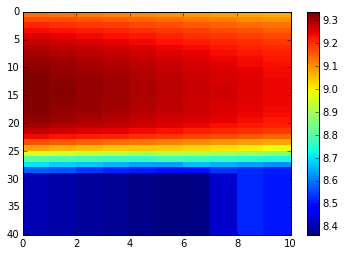

In [6]:
plt.pcolormesh(Tmean[0,:,:])
plt.axis([0,nrim,ndepth,0])
plt.colorbar()

Looks reasonable.

#Copy across Y

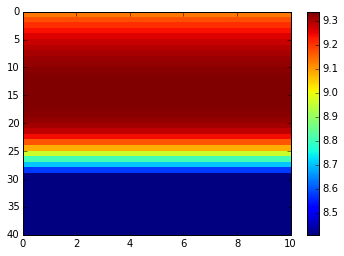

In [7]:
Ny=10 #only 8 because of masked edges 
T_y=np.tile(Tmean,Ny)
T_y=T_y.reshape(ntime,ndepth,Ny,nrim)
T_y.shape

plt.pcolormesh(T_y[0,:,:,0])
plt.axis([0,Ny,ndepth,0])
plt.colorbar()

29.5011062622


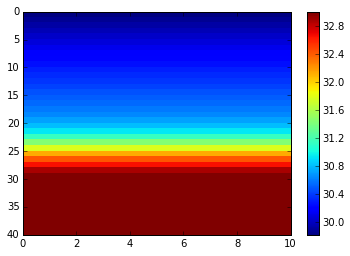

In [8]:

S_y=np.tile(Smean,Ny)
S_y=S_y.reshape(ntime,ndepth,Ny,nrim)
S_y.shape

plt.pcolormesh(S_y[0,:,:,3])
plt.axis([0,Ny,ndepth,0])
plt.colorbar()

print (S_y.min())

#Untile
Need to order the data from closest to the edge to furthest from the edge

In [9]:
T_untile = np.zeros((ntime,ndepth,1,Ny*nrim))
S_untile = np.zeros((ntime,ndepth,1,Ny*nrim))
for i in np.arange(nrim):
    ind = i*Ny
    T_untile[:,:,0,ind:ind+Ny] = T_y[:,:,:,i]
    S_untile[:,:,0,ind:ind+Ny] = S_y[:,:,:,i]

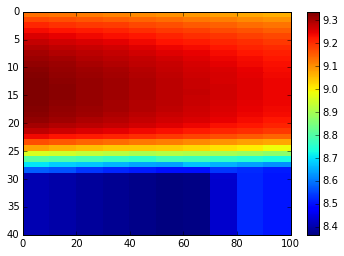

In [10]:
plt.pcolormesh(T_untile[0,:,0,:])
plt.axis([0,Ny*nrim,ndepth,0])
plt.colorbar()

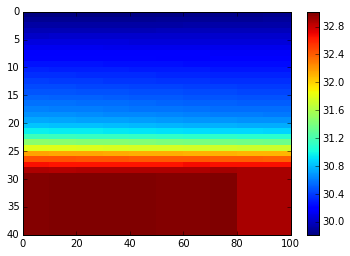

In [11]:
plt.pcolormesh(S_untile[0,:,0,:])
plt.axis([0,Ny*nrim,ndepth,0])
plt.colorbar()

#Save to netcdf

In [12]:
nemo = nc.Dataset('/ocean/eolson/MEOPAR/NEMO-3.6-inputs/boundary_conditions/TS_OBC.nc', 'w', zlib=True)

#start and end points
length_rim =nrim
lengthi=Ny*length_rim
#time and depth
depth_levels =ndepth


# dataset attributes
#nc_tools.init_dataset_attrs(
#    nemo,
#    title='Temperature and Salinty Boundary Conditions 2D domain',
#    notebook_name='Generate T+S Forcing - NEMO3.6',
#    nc_filepath='/data/nsoontie/MEOPAR/2Ddomain/TS_OBC.nc',
#    comment='based on average values across mouth of JdF and 3D weekly climatology')

# dimensions 
nemo.createDimension('xb', lengthi)
nemo.createDimension('yb', 1)
nemo.createDimension('time_counter', None)
nemo.createDimension('deptht', depth_levels)
    
# variables
# deptht
deptht = nemo.createVariable('deptht', 'float32', ('deptht',))
deptht.long_name = 'Vertical T Levels'
deptht.units = 'm'
deptht.positive = 'down'
deptht.valid_range = np.array((4., 428.))
deptht[:]=depth
# time_counter
time_counter = nemo.createVariable('time_counter', 'float32', ('time_counter'))
time_counter.long_name = 'Time axis'
time_counter.axis = 'T'
time_counter.units = 'weeks since beginning of year'
time_counter[:]=times
# votemper
votemper = nemo.createVariable('votemper', 'float32', 
                               ('time_counter','deptht','yb','xb'))
votemper.units = 'degC'
votemper.long_name = 'Temperature'   
votemper.grid = 'SalishSea2D'
votemper[:]=T_untile
# vosaline
vosaline = nemo.createVariable('vosaline', 'float32', 
                               ('time_counter','deptht','yb','xb'))
vosaline.units = 1
vosaline.long_name = 'Practical Salinity'  
vosaline.grid = 'SalishSea2D'
vosaline[:]=S_untile
# nbidta, ndjdta, ndrdta
nbidta = nemo.createVariable('nbidta', 'int32' , ('yb','xb'))
nbidta.long_name = 'i grid position'
nbidta.units = 1
nbjdta = nemo.createVariable('nbjdta', 'int32' , ('yb','xb'))
nbjdta.long_name = 'j grid position'
nbjdta.units = 1
nbrdta = nemo.createVariable('nbrdta', 'int32' , ('yb','xb'))
nbrdta.long_name = 'position from boundary'
nbrdta.units = 1
    
for ir in range(length_rim):
    nbidta[0,ir*Ny:(ir+1)*Ny] = ir
    nbjdta[0,ir*Ny:(ir+1)*Ny] = range(Ny)
    nbrdta[0,ir*Ny:(ir+1)*Ny] = ir
    
nemo.close()